In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

class ResidualBlock(nn.Module):
    """
    A residual block as defined by He et al.
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(ResidualBlock, self).__init__()
        self.conv_res1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, stride=stride, bias=False)
        self.conv_res1_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
        self.conv_res2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, bias=False)
        self.conv_res2_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)

        if stride != 1:
            # in case stride is not set to 1, we need to downsample the residual so that
            # the dimensions are the same when we add them together
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x

        out = self.relu(self.conv_res1_bn(self.conv_res1(x)))
        out = self.conv_res2_bn(self.conv_res2(out))

        if self.downsample is not None:
            residual = self.downsample(residual)

        out = self.relu(out)
        out = out + residual
        return out


class Net(nn.Module):
    """
    A Residual network.
    """
    def __init__(self):
        super(Net, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(in_features=1024, out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out

In [ ]:
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = Net().to(device)
summary(model, (3,32,32))


Using cuda device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
    ResidualBlock-14 

In [ ]:
batch_size = 128
# batch_size = 256
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(len(trainloader))
for X,y in trainloader:
  print(X.shape)
  print(y.shape)
  print(X[0])
  break

391
torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor([[[-2.4291, -2.4291, -1.1109,  ..., -1.2078, -1.3629, -1.2660],
         [-2.4291, -2.4291, -1.2078,  ..., -0.8977, -0.2580, -1.0334],
         [-2.4291, -2.4291, -1.2078,  ...,  0.8858,  1.4285, -0.6069],
         ...,
         [-2.4291, -2.4291, -1.3435,  ..., -1.5761, -1.7118, -1.5180],
         [-2.4291, -2.4291, -1.2854,  ..., -1.2272, -1.5180, -1.4211],
         [-2.4291, -2.4291, -0.9946,  ..., -1.0915, -1.2660, -1.2854]],

        [[-2.4183, -2.4183, -0.7269,  ..., -0.8842, -1.0612, -0.9826],
         [-2.4183, -2.4183, -0.8252,  ..., -0.6679, -0.0582, -0.8252],
         [-2.4183, -2.4183, -0.8056,  ...,  1.0038,  1.5151, -0.4909],
         ...,
         [-2.4183, -2.4183, -0.9236,  ..., -1.3366, -1.4349, -1.2186],
         [-2.4183, -2.4183, -0.9236,  ..., -1.0416, -1.2382, -1.1202],
         [-2.4183, -2.4183, -0.6876,  ..., -0.8449, -0.9826, -1.0022]],

        [[-2.2214, -2.2214, -0.8947,  ..., -1.3239, -1.4020, -1.3

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
train_acc = []
test_acc = []

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  correct = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad(set_to_none=True) # set_to_none=False
    loss.backward()  
    optimizer.step()  # update the parameters in neural network

    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    if batch % 100 == 0:
      loss, current = loss.item(), batch*len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
  train_acc.append(correct/size)   

In [ ]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  test_acc.append(correct)
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [ ]:
epochs = 100
for i in range(epochs):
  print(f"Epoch {i+1}\n------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!")

Epoch 1
------------------------
loss: 2.681243 [    0/50000]
loss: 1.504132 [12800/50000]
loss: 1.375795 [25600/50000]
loss: 1.185612 [38400/50000]
Test Error: 
 Accuracy: 68.9%, Avg loss: 0.884024

Epoch 2
------------------------
loss: 0.862228 [    0/50000]
loss: 0.956537 [12800/50000]
loss: 0.783224 [25600/50000]
loss: 0.710763 [38400/50000]
Test Error: 
 Accuracy: 74.2%, Avg loss: 0.755471

Epoch 3
------------------------
loss: 0.799936 [    0/50000]
loss: 0.648053 [12800/50000]
loss: 0.676547 [25600/50000]
loss: 0.548179 [38400/50000]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.628567

Epoch 4
------------------------
loss: 0.685970 [    0/50000]
loss: 0.485926 [12800/50000]
loss: 0.525579 [25600/50000]
loss: 0.439979 [38400/50000]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.610843

Epoch 5
------------------------
loss: 0.438346 [    0/50000]
loss: 0.462779 [12800/50000]
loss: 0.498927 [25600/50000]
loss: 0.467446 [38400/50000]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.512903



In [ ]:
train_acc

[0.52288,
 0.71652,
 0.77322,
 0.8069,
 0.83084,
 0.84912,
 0.86058,
 0.87546,
 0.88232,
 0.89146,
 0.90198,
 0.90912,
 0.91374,
 0.91796,
 0.92338,
 0.92956,
 0.93364,
 0.93664,
 0.94062,
 0.94536,
 0.94864,
 0.95032,
 0.953,
 0.95604,
 0.95962,
 0.95824,
 0.96198,
 0.96458,
 0.96406,
 0.96636,
 0.96724,
 0.96714,
 0.97142,
 0.97206,
 0.97126,
 0.9714,
 0.97282,
 0.97382,
 0.9738,
 0.97656,
 0.97446,
 0.97654,
 0.97688,
 0.97816,
 0.97604,
 0.97768,
 0.97852,
 0.97768,
 0.97992,
 0.97956,
 0.97938,
 0.97934,
 0.98054,
 0.98082,
 0.9814,
 0.9824,
 0.98156,
 0.98128,
 0.97906,
 0.982,
 0.98156,
 0.98246,
 0.98394,
 0.9825,
 0.98306,
 0.98304,
 0.98294,
 0.98408,
 0.9857,
 0.98444,
 0.9822,
 0.9848,
 0.9835,
 0.98622,
 0.984,
 0.9832,
 0.98508,
 0.98586,
 0.98366,
 0.98568,
 0.98436,
 0.98564,
 0.98446,
 0.98408,
 0.98686,
 0.98538,
 0.98714,
 0.98464,
 0.98576,
 0.98622,
 0.98614,
 0.9864,
 0.98772,
 0.98498,
 0.98626,
 0.9853,
 0.98464,
 0.98594,
 0.9869,
 0.98794]

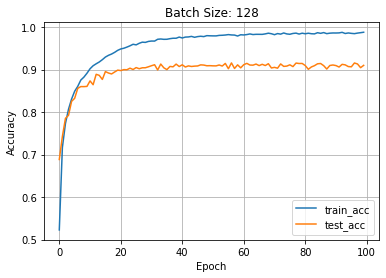

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(epochs)]
plt.plot(x,train_acc, label = 'train_acc')
plt.plot(x,test_acc, label = 'test_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Batch Size: 128')
# plt.title('Batch Size: 256')
plt.grid()
plt.show()